In [ ]:
## git clone 및 데이터 다운로드 
# import os
# os.chdir('/content/drive/My Drive/Project/TTS_audiobook')
# os.getcwd()
# !git clone https://github.com/TensorSpeech/TensorFlowTTS.git
# os.chdir("TensorFlowTTS")
# !pip install .
# os.chdir("..")

# import sys
# sys.path.append("TensorFlowTTS/")

# # data link : https://www.kaggle.com/bryanpark/korean-single-speaker-speech-dataset

In [ ]:
## exampls module 코랩 다른 모듈과 충동 -> 이름 바꿔주기 
# from pathlib import Path
# import shutil

# for path in Path(os.getcwd()).rglob('*.py'):
#   flis = list()
#   with open(path,"r") as f:
#     flis = f.readlines()
  
#   rep = open(path,"w")
#   for fl in flis:
#     nuli = fl
#     if "examples." in fl:
#       nuli = nuli.replace("examples.","ttsexamples.")
#       print(nuli.strip())


#     rep.write(nuli)
  
#   rep.close()

# shutil.move("examples","ttsexamples")

In [ ]:
# 이미 git clone이 되어 있다면 이 셀을 실행 
import os
os.chdir('/content/drive/My Drive/Project/TTS_audiobook/TensorFlowTTS')
print(os.getcwd())
! pip install TensorFlowTTS

import sys
sys.path.append("TensorFlowTTS/")

In [ ]:
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


## HParams

In [ ]:
class Tacotron2Config(object):
    """Initialize Tacotron-2 Config."""

    def __init__(
        self,
        dataset='kss',
        vocab_size=81,
        n_mels=80, 
        embedding_hidden_size=512, 
        initializer_range=0.02,
        layer_norm_eps=1e-6,
        embedding_dropout_prob=0.1,
        n_speakers=1,
        n_conv_encoder=3,
        encoder_conv_filters=512,
        encoder_conv_kernel_sizes=5,
        encoder_conv_activation="mish",
        encoder_conv_dropout_rate=0.5,
        encoder_lstm_units=256,
        reduction_factor=5,
        n_prenet_layers=2,
        prenet_units=256,
        prenet_activation="mish",
        prenet_dropout_rate=0.5,
        n_lstm_decoder=1,
        decoder_lstm_units=1024,
        attention_type="lsa",
        attention_dim=128,
        attention_filters=32,
        attention_kernel=31,
        n_conv_postnet=5,
        postnet_conv_filters=512,
        postnet_conv_kernel_sizes=5,
        postnet_dropout_rate=0.1,
    ):

        """Init parameters for Tacotron-2 model."""
        self.vocab_size = 81 #len(kss_symbols)
        self.embedding_hidden_size = embedding_hidden_size #text embedding 차수 
        self.initializer_range = initializer_range
        self.layer_norm_eps = layer_norm_eps
        self.embedding_dropout_prob = embedding_dropout_prob
        self.n_speakers = n_speakers
        self.n_conv_encoder = n_conv_encoder
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_sizes = encoder_conv_kernel_sizes
        self.encoder_conv_activation = encoder_conv_activation
        self.encoder_conv_dropout_rate = encoder_conv_dropout_rate
        self.encoder_lstm_units = encoder_lstm_units

        # decoder param
        self.reduction_factor = reduction_factor
        self.n_prenet_layers = n_prenet_layers
        self.prenet_units = prenet_units
        self.prenet_activation = prenet_activation
        self.prenet_dropout_rate = prenet_dropout_rate
        self.n_lstm_decoder = n_lstm_decoder
        self.decoder_lstm_units = decoder_lstm_units
        self.attention_type = attention_type
        self.attention_dim = attention_dim
        self.attention_filters = attention_filters
        self.attention_kernel = attention_kernel
        self.n_mels = n_mels #mel spectrogram 차수 

        # postnet
        self.n_conv_postnet = n_conv_postnet
        self.postnet_conv_filters = postnet_conv_filters
        self.postnet_conv_kernel_sizes = postnet_conv_kernel_sizes
        self.postnet_dropout_rate = postnet_dropout_rate

## 데이터 전처리

### 한국어 전처리

In [ ]:
# 한국어 전처리 코드 (korean.py)
# Son data를 위한 딕셔너리 등은 코드 간략화를 위해 삭제 

import ast
import json
import os
import re

from jamo import h2j, hangul_to_jamo, j2h, jamo_to_hcj

num_to_kor = {
    "0": "영",
    "1": "일",
    "2": "이",
    "3": "삼",
    "4": "사",
    "5": "오",
    "6": "육",
    "7": "칠",
    "8": "팔",
    "9": "구",
}

unit_to_kor1 = {"%": "퍼센트", "cm": "센치미터", "mm": "밀리미터", "km": "킬로미터", "kg": "킬로그람"}
unit_to_kor2 = {"m": "미터"}

upper_to_kor = {
    "A": "에이",
    "B": "비",
    "C": "씨",
    "D": "디",
    "E": "이",
    "F": "에프",
    "G": "지",
    "H": "에이치",
    "I": "아이",
    "J": "제이",
    "K": "케이",
    "L": "엘",
    "M": "엠",
    "N": "엔",
    "O": "오",
    "P": "피",
    "Q": "큐",
    "R": "알",
    "S": "에스",
    "T": "티",
    "U": "유",
    "V": "브이",
    "W": "더블유",
    "X": "엑스",
    "Y": "와이",
    "Z": "지",
}


"""
초성과 종성은 같아보이지만, 다른 character이다.

'_-!'(),-.:;? ᄀᄁᄂᄃᄄᄅᄆᄇᄈᄉᄊᄋᄌᄍᄎᄏᄐᄑ하ᅢᅣᅤᅥᅦᅧᅨᅩᅪᅫᅬᅭᅮᅯᅰᅱᅲᅳᅴᅵᆨᆩᆪᆫᆬᆭᆮᆯᆰᆱᆲᆳᆴᆵᆶᆷᆸᆹᆺᆻᆼᆽᆾᆿᇀᇁᇂ~'

'_': 0, '-': 7, '!': 2, "'": 3, '(': 4, ')': 5, ',': 6, '.': 8, ':': 9, ';': 10,
'?': 11, ' ': 12, 'ᄀ': 13, 'ᄁ': 14, 'ᄂ': 15, 'ᄃ': 16, 'ᄄ': 17, 'ᄅ': 18, 'ᄆ': 19, 'ᄇ': 20,
'ᄈ': 21, 'ᄉ': 22, 'ᄊ': 23, 'ᄋ': 24, 'ᄌ': 25, 'ᄍ': 26, 'ᄎ': 27, 'ᄏ': 28, 'ᄐ': 29, 'ᄑ': 30,
'ᄒ': 31, 'ᅡ': 32, 'ᅢ': 33, 'ᅣ': 34, 'ᅤ': 35, 'ᅥ': 36, 'ᅦ': 37, 'ᅧ': 38, 'ᅨ': 39, 'ᅩ': 40,
'ᅪ': 41, 'ᅫ': 42, 'ᅬ': 43, 'ᅭ': 44, 'ᅮ': 45, 'ᅯ': 46, 'ᅰ': 47, 'ᅱ': 48, 'ᅲ': 49, 'ᅳ': 50,
'ᅴ': 51, 'ᅵ': 52, 'ᆨ': 53, 'ᆩ': 54, 'ᆪ': 55, 'ᆫ': 56, 'ᆬ': 57, 'ᆭ': 58, 'ᆮ': 59, 'ᆯ': 60,
'ᆰ': 61, 'ᆱ': 62, 'ᆲ': 63, 'ᆳ': 64, 'ᆴ': 65, 'ᆵ': 66, 'ᆶ': 67, 'ᆷ': 68, 'ᆸ': 69, 'ᆹ': 70,
'ᆺ': 71, 'ᆻ': 72, 'ᆼ': 73, 'ᆽ': 74, 'ᆾ': 75, 'ᆿ': 76, 'ᇀ': 77, 'ᇁ': 78, 'ᇂ': 79, '~': 80
"""

_pad = "pad"
_eos = "eos"
_punctuation = "!'(),-.:;? "
_special = "-"

_jamo_leads = [chr(_) for _ in range(0x1100, 0x1113)]
_jamo_vowels = [chr(_) for _ in range(0x1161, 0x1176)]
_jamo_tails = [chr(_) for _ in range(0x11A8, 0x11C3)]

_letters = _jamo_leads + _jamo_vowels + _jamo_tails

symbols = [_pad] + list(_special) + list(_punctuation) + _letters + [_eos]

_symbol_to_id = {c: i for i, c in enumerate(symbols)}
_id_to_symbol = {i: c for i, c in enumerate(symbols)}

quote_checker = """([`"'＂“‘])(.+?)([`"'＂”’])"""


def is_lead(char):
    return char in _jamo_leads


def is_vowel(char):
    return char in _jamo_vowels


def is_tail(char):
    return char in _jamo_tails


def get_mode(char):
    if is_lead(char):
        return 0
    elif is_vowel(char):
        return 1
    elif is_tail(char):
        return 2
    else:
        return -1


def _get_text_from_candidates(candidates):
    if len(candidates) == 0:
        return ""
    elif len(candidates) == 1:
        return jamo_to_hcj(candidates[0])
    else:
        return j2h(**dict(zip(["lead", "vowel", "tail"], candidates)))


def jamo_to_korean(text):
    text = h2j(text)

    idx = 0
    new_text = ""
    candidates = []

    while True:
        if idx >= len(text):
            new_text += _get_text_from_candidates(candidates)
            break

        char = text[idx]
        mode = get_mode(char)

        if mode == 0:
            new_text += _get_text_from_candidates(candidates)
            candidates = [char]
        elif mode == -1:
            new_text += _get_text_from_candidates(candidates)
            new_text += char
            candidates = []
        else:
            candidates.append(char)

        idx += 1
    return new_text


def compare_sentence_with_jamo(text1, text2):
    return h2j(text1) != h2j(text2)


def tokenize(text, as_id=False):
    # jamo package에 있는 hangul_to_jamo를 이용하여 한글 string을 초성/중성/종성으로 나눈다.
    text = normalize(text)
    tokens = list(
        hangul_to_jamo(text)
    )  # '존경하는'  --> ['ᄌ', 'ᅩ', 'ᆫ', 'ᄀ', 'ᅧ', 'ᆼ', 'ᄒ', 'ᅡ', 'ᄂ', 'ᅳ', 'ᆫ', '~']

    if as_id:
        return [_symbol_to_id[token] for token in tokens]
    else:
        return [token for token in tokens]


def tokenizer_fn(iterator):
    return (token for x in iterator for token in tokenize(x, as_id=False))


def normalize(text):
    text = text.strip()

    text = re.sub("\(\d+일\)", "", text)
    text = normalize_with_dictionary(text, etc_dictionary)
    text = normalize_english(text)
    text = re.sub("[a-zA-Z]+", normalize_upper, text)

    text = normalize_quote(text)
    text = normalize_number(text)

    return text


def normalize_with_dictionary(text, dic):
    if any(key in text for key in dic.keys()):
        pattern = re.compile("|".join(re.escape(key) for key in dic.keys()))
        return pattern.sub(lambda x: dic[x.group()], text)
    else:
        return text


def normalize_english(text):
    def fn(m):
        word = m.group()
        if word in english_dictionary:
            return english_dictionary.get(word)
        else:
            return word

    text = re.sub("([A-Za-z]+)", fn, text)
    return text


def normalize_upper(text):
    text = text.group(0)

    if all([char.isupper() for char in text]):
        return "".join(upper_to_kor[char] for char in text)
    else:
        return text


def normalize_quote(text):
    def fn(found_text):
        from nltk import sent_tokenize  # NLTK doesn't along with multiprocessing

        found_text = found_text.group()
        unquoted_text = found_text[1:-1]

        sentences = sent_tokenize(unquoted_text)
        return " ".join(["'{}'".format(sent) for sent in sentences])

    return re.sub(quote_checker, fn, text)


number_checker = "([+-]?\d[\d,]*)[\.]?\d*"
count_checker = "(시|명|가지|살|마리|포기|송이|수|톨|통|점|개|벌|척|채|다발|그루|자루|줄|켤레|그릇|잔|마디|상자|사람|곡|병|판)"


def normalize_number(text):
    text = normalize_with_dictionary(text, unit_to_kor1)
    text = normalize_with_dictionary(text, unit_to_kor2)
    text = re.sub(
        number_checker + count_checker, lambda x: number_to_korean(x, True), text
    )
    text = re.sub(number_checker, lambda x: number_to_korean(x, False), text)
    return text


num_to_kor1 = [""] + list("일이삼사오육칠팔구")
num_to_kor2 = [""] + list("만억조경해")
num_to_kor3 = [""] + list("십백천")

# count_to_kor1 = [""] + ["하나","둘","셋","넷","다섯","여섯","일곱","여덟","아홉"]
count_to_kor1 = [""] + ["한", "두", "세", "네", "다섯", "여섯", "일곱", "여덟", "아홉"]

count_tenth_dict = {
    "십": "열",
    "두십": "스물",
    "세십": "서른",
    "네십": "마흔",
    "다섯십": "쉰",
    "여섯십": "예순",
    "일곱십": "일흔",
    "여덟십": "여든",
    "아홉십": "아흔",
}


def number_to_korean(num_str, is_count=False):
    if is_count:
        num_str, unit_str = num_str.group(1), num_str.group(2)
    else:
        num_str, unit_str = num_str.group(), ""

    num_str = num_str.replace(",", "")
    num = ast.literal_eval(num_str)

    if num == 0:
        return "영"

    check_float = num_str.split(".")
    if len(check_float) == 2:
        digit_str, float_str = check_float
    elif len(check_float) >= 3:
        raise Exception(" [!] Wrong number format")
    else:
        digit_str, float_str = check_float[0], None

    if is_count and float_str is not None:
        raise Exception(" [!] `is_count` and float number does not fit each other")

    digit = int(digit_str)

    if digit_str.startswith("-"):
        digit, digit_str = abs(digit), str(abs(digit))

    kor = ""
    size = len(str(digit))
    tmp = []

    for i, v in enumerate(digit_str, start=1):
        v = int(v)

        if v != 0:
            if is_count:
                tmp += count_to_kor1[v]
            else:
                tmp += num_to_kor1[v]

            tmp += num_to_kor3[(size - i) % 4]

        if (size - i) % 4 == 0 and len(tmp) != 0:
            kor += "".join(tmp)
            tmp = []
            kor += num_to_kor2[int((size - i) / 4)]

    if is_count:
        if kor.startswith("한") and len(kor) > 1:
            kor = kor[1:]

        if any(word in kor for word in count_tenth_dict):
            kor = re.sub(
                "|".join(count_tenth_dict.keys()),
                lambda x: count_tenth_dict[x.group()],
                kor,
            )

    if not is_count and kor.startswith("일") and len(kor) > 1:
        kor = kor[1:]

    if float_str is not None:
        kor += "쩜 "
        kor += re.sub("\d", lambda x: num_to_kor[x.group()], float_str)

    if num_str.startswith("+"):
        kor = "플러스 " + kor
    elif num_str.startswith("-"):
        kor = "마이너스 " + kor

    return kor + unit_str


In [ ]:
len(symbols) #한국어 character embedding할 개수 

81

In [ ]:
# KSS 데이터 processor
import os
import re

import numpy as np
import soundfile as sf
from dataclasses import dataclass
from tensorflow_tts.processor import BaseProcessor
from tensorflow_tts.utils import cleaners
from tensorflow_tts.utils.korean import symbols as KSS_SYMBOLS

# Regular expression matching text enclosed in curly braces:
_curly_re = re.compile(r"(.*?)\{(.+?)\}(.*)")


@dataclass
class KSSProcessor(BaseProcessor):
    """KSS processor."""

    cleaner_names: str = "korean_cleaners"
    positions = {
        "wave_file": 0,
        "text_norm": 2,
    }
    train_f_name: str = "transcript.v.1.4.txt"

    def create_items(self):
        if self.data_dir:
            with open(
                os.path.join(self.data_dir, self.train_f_name), encoding="utf-8"
            ) as f:
                self.items = [self.split_line(self.data_dir, line, "|") for line in f]

    def split_line(self, data_dir, line, split):
        parts = line.strip().split(split)
        wave_file = parts[self.positions["wave_file"]]
        text_norm = parts[self.positions["text_norm"]]
        wav_path = os.path.join(data_dir, "kss", wave_file)
        speaker_name = "kss"
        return text_norm, wav_path, speaker_name

    def setup_eos_token(self):
        return "eos"

    def get_one_sample(self, item):
        text, wav_path, speaker_name = item

        # normalize audio signal to be [-1, 1], soundfile already norm.
        audio, rate = sf.read(wav_path)
        audio = audio.astype(np.float32)

        # convert text to ids
        text_ids = np.asarray(self.text_to_sequence(text), np.int32)

        sample = {
            "raw_text": text,
            "text_ids": text_ids,
            "audio": audio,
            "utt_id": os.path.split(wav_path)[-1].split(".")[0],
            "speaker_name": speaker_name,
            "rate": rate,
        }

        return sample

    def text_to_sequence(self, text):

        sequence = []
        # Check for curly braces and treat their contents as ARPAbet:
        while len(text):
            m = _curly_re.match(text)
            if not m:
                sequence += self._symbols_to_sequence(
                    self._clean_text(text, [self.cleaner_names])
                )
                break
            sequence += self._symbols_to_sequence(
                self._clean_text(m.group(1), [self.cleaner_names])
            )
            sequence += self._arpabet_to_sequence(m.group(2))
            text = m.group(3)

        # add eos tokens
        sequence += [self.eos_id]
        return sequence

    def _clean_text(self, text, cleaner_names):
        for name in cleaner_names:
            cleaner = getattr(cleaners, name)
            if not cleaner:
                raise Exception("Unknown cleaner: %s" % name)
            text = cleaner(text)
        return text

    def _symbols_to_sequence(self, symbols):
        return [self.symbol_to_id[s] for s in symbols if self._should_keep_symbol(s)]

    def _arpabet_to_sequence(self, text):
        return self._symbols_to_sequence(["@" + s for s in text.split()])

    def _should_keep_symbol(self, s):
        return s in self.symbol_to_id and s != "_" and s != "~"

### Preprocessing

In [ ]:
import argparse
import glob
import logging
import os
import yaml
import easydict
import librosa
import numpy as np
import pyworld as pw

from functools import partial
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from tensorflow_tts.processor import KSSProcessor
from tensorflow_tts.processor.kss import KSS_SYMBOLS

from tensorflow_tts.utils import remove_outlier

In [ ]:
#  preprocess 전용 함수들 

def parse_and_config():
    args = easydict.EasyDict({ "rootdir": './kss', 
                              "outdir": './dump_test', 
                              "dataset": 'kss', 
                              "config": "./preprocess/kss_preprocess.yaml", 
                              "n_cpus": 4, 
                              "test_size": 0.05,
                              "verbose":0})
      # set logger
    FORMAT = "%(asctime)s (%(module)s:%(lineno)d) %(levelname)s: %(message)s"
    log_level = {0: logging.DEBUG, 1: logging.WARNING, 2: logging.ERROR}
    logging.basicConfig(level=log_level[args.verbose], format=FORMAT)

    # load config
    config = yaml.load(open(args.config), Loader=yaml.Loader)
    config.update(vars(args))
    # config checks
    assert config["format"] == "npy", "'npy' is the only supported format."
    return config


def ph_based_trim(
    config,
    utt_id: str,
    text_ids: np.array,
    raw_text: str,
    audio: np.array,
    hop_size: int,
) -> (bool, np.array, np.array):
    """
    Args:
        config: Parsed yaml config
        utt_id: file name
        text_ids: array with text ids
        raw_text: raw text of file
        audio: parsed wav file
        hop_size: Hop size
    Returns: (bool, np.array, np.array) => if trimmed return True, new text_ids, new audio_array
    """

    os.makedirs(os.path.join(config["rootdir"], "trimmed-durations"), exist_ok=True)
    duration_path = config.get(
        "duration_path", os.path.join(config["rootdir"], "durations")
    )
    duration_fixed_path = config.get(
        "duration_fixed_path", os.path.join(config["rootdir"], "trimmed-durations")
    )
    sil_ph = ["SIL", "END"]  # TODO FIX hardcoded values
    text = raw_text.split(" ")

    trim_start, trim_end = False, False

    if text[0] in sil_ph:
        trim_start = True

    if text[-1] in sil_ph:
        trim_end = True

    if not trim_start and not trim_end:
        return False, text_ids, audio

    idx_start, idx_end = (
        0 if not trim_start else 1,
        text_ids.__len__() if not trim_end else -1,
    )
    text_ids = text_ids[idx_start:idx_end]
    durations = np.load(os.path.join(duration_path, f"{utt_id}-durations.npy"))
    if trim_start:
        s_trim = int(durations[0] * hop_size)
        audio = audio[s_trim:]
    if trim_end:
        e_trim = int(durations[-1] * hop_size)
        audio = audio[:-e_trim]

    durations = durations[idx_start:idx_end]
    np.save(os.path.join(duration_fixed_path, f"{utt_id}-durations.npy"), durations)
    return True, text_ids, audio


def gen_audio_features(item, config):
    """Generate audio features and transformations
    Args:
        item (Dict): dictionary containing the attributes to encode.
        config (Dict): configuration dictionary.
    Returns:
        (bool): keep this sample or not.
        mel (ndarray): mel matrix in np.float32.
        energy (ndarray): energy audio profile.
        f0 (ndarray): fundamental frequency.
        item (Dict): dictionary containing the updated attributes.
        
        
# sample_rate: 오디오(신호) 데이터의 표본 비율(속도)
# mel spectrogram의 차수
# win_length: short time analysis를 하기위한 window의 길이
# hop_length: 얼만큼씩 이동시킬 것인가 => 즉, 1024 length의 윈도우를 256만큼 조금씩 이동시켜가면서 분석을 진행
# f_min, f_max: fundamental freq(사람 음성)의 바운더리 설정 => 계산용이를 위해 / 각자 제공하는 코드에 맞게 스케일을 맞출것
# n_fft: fft size => FT(Fourier Transform, 푸리에 변환)는 시간에 대한 함수(신호)를 주파수 성분으로 분해하는 작업        

    """
    
    # get info from sample.
    audio = item["audio"]
    utt_id = item["utt_id"]
    rate = item["rate"]

    # check audio properties
    assert len(audio.shape) == 1, f"{utt_id} seems to be multi-channel signal."
    assert np.abs(audio).max() <= 1.0, f"{utt_id} is different from 16 bit PCM."
    
    # check sample rate
    if rate != config["sampling_rate"]:
        audio = librosa.resample(audio, rate, config["sampling_rate"])
        logging.info(f"{utt_id} sampling rate is {rate}, not {config['sampling_rate']}, we resample it.")

    # trim silence
    if config["trim_silence"]:
        if "trim_mfa" in config and config["trim_mfa"]:
            _, item["text_ids"], audio = ph_based_trim(
                config,
                utt_id,
                item["text_ids"],
                item["raw_text"],
                audio,
                config["hop_size"],
            )
            if (
                audio.__len__() < 1
            ):  # very short files can get trimmed fully if mfa didnt extract any tokens LibriTTS maybe take only longer files?
                logging.warning(
                    f"File have only silence or MFA didnt extract any token {utt_id}"
                )
                return False, None, None, None, item
        else:
            audio, _ = librosa.effects.trim(
                audio,
                top_db=config["trim_threshold_in_db"],
                frame_length=config["trim_frame_size"],
                hop_length=config["trim_hop_size"],
            )

    # resample audio if necessary
    if "sampling_rate_for_feats" in config:
        audio = librosa.resample(audio, rate, config["sampling_rate_for_feats"])
        sampling_rate = config["sampling_rate_for_feats"]
        assert (
            config["hop_size"] * config["sampling_rate_for_feats"] % rate == 0
        ), "'hop_size' must be 'int' value. Please check if 'sampling_rate_for_feats' is correct."
        hop_size = config["hop_size"] * config["sampling_rate_for_feats"] // rate
    else:
        sampling_rate = config["sampling_rate"]
        hop_size = config["hop_size"]

    # get spectrogram
    D = librosa.stft(
        audio,
        n_fft=config["fft_size"],
        hop_length=hop_size,
        win_length=config["win_length"],
        window=config["window"],
        pad_mode="reflect",
    )
    S, _ = librosa.magphase(D)  # (#bins, #frames)

    # get mel basis
    fmin = 0 if config["fmin"] is None else config["fmin"]
    fmax = sampling_rate // 2 if config["fmax"] is None else config["fmax"]
    mel_basis = librosa.filters.mel(
        sr=sampling_rate,
        n_fft=config["fft_size"],
        n_mels=config["num_mels"],
        fmin=fmin,
        fmax=fmax,
    )
    mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T  # (#frames, #bins)

    # check audio and feature length
    audio = np.pad(audio, (0, config["fft_size"]), mode="edge")
    audio = audio[: len(mel) * hop_size]
    assert len(mel) * hop_size == len(audio)

    # extract raw pitch
    _f0, t = pw.dio(
        audio.astype(np.double),
        fs=sampling_rate,
        f0_ceil=fmax,
        frame_period=1000 * hop_size / sampling_rate,
    )
    f0 = pw.stonemask(audio.astype(np.double), _f0, t, sampling_rate)
    if len(f0) >= len(mel):
        f0 = f0[: len(mel)]
    else:
        f0 = np.pad(f0, (0, len(mel) - len(f0)))

    # extract energy
    energy = np.sqrt(np.sum(S ** 2, axis=0))
    assert len(mel) == len(f0) == len(energy)

    # remove outlier f0/energy
    f0 = remove_outlier(f0)
    energy = remove_outlier(energy)

    # apply global gain
    if config["global_gain_scale"] > 0.0:
        audio *= config["global_gain_scale"]
    if np.abs(audio).max() >= 1.0:
        logging.warn(
            f"{utt_id} causes clipping. It is better to reconsider global gain scale value."
        )
    item["audio"] = audio
    item["mel"] = mel
    item["f0"] = f0
    item["energy"] = energy
    return True, mel, energy, f0, item


def save_statistics_to_file(scaler_list, config):
    """Save computed statistics to disk.
    Args:
        scaler_list (List): List of scalers containing statistics to save.
        config (Dict): configuration dictionary.
    """
    for scaler, name in scaler_list:
        stats = np.stack((scaler.mean_, scaler.scale_))
        np.save(
            os.path.join(config["outdir"], f"stats{name}.npy"),
            stats.astype(np.float32),
            allow_pickle=False,
        )


def save_features_to_file(features, subdir, config):
    """Save transformed dataset features in disk.
    Args:
        features (Dict): dictionary containing the attributes to save.
        subdir (str): data split folder where features will be saved.
        config (Dict): configuration dictionary.
    """
    utt_id = features["utt_id"]

    if config["format"] == "npy":
        save_list = [
            (features["audio"], "wavs", "wave", np.float32),
            (features["mel"], "raw-feats", "raw-feats", np.float32),
            (features["text_ids"], "ids", "ids", np.int32),
            (features["f0"], "raw-f0", "raw-f0", np.float32),
            (features["energy"], "raw-energies", "raw-energy", np.float32),
        ]
        for item, name_dir, name_file, fmt in save_list:
            np.save(
                os.path.join(
                    config["outdir"], subdir, name_dir, f"{utt_id}-{name_file}.npy"
                ),
                item.astype(fmt),
                allow_pickle=False,
            )
    else:
        raise ValueError("'npy' is the only supported format.")

In [ ]:
# Hyperparameters 파싱

def parse_and_config():
    args = easydict.EasyDict({ "rootdir": './kss', 
                              "outdir": './dump_test', 
                              "dataset": 'kss', 
                              "config": "./preprocess/kss_preprocess.yaml", 
                              "n_cpus": 4, 
                              "test_size": 0.05,
                              "verbose":0})
      # set logger
    FORMAT = "%(asctime)s (%(module)s:%(lineno)d) %(levelname)s: %(message)s"
    log_level = {0: logging.DEBUG, 1: logging.WARNING, 2: logging.ERROR}
    logging.basicConfig(level=log_level[args.verbose], format=FORMAT)

    # load config
    config = yaml.load(open(args.config), Loader=yaml.Loader)
    config.update(vars(args))
    # config checks
    assert config["format"] == "npy", "'npy' is the only supported format."
    return config

In [ ]:
def preprocess():
    """Run preprocessing process and compute statistics for normalizing."""
    config = parse_and_config()

    dataset_processor = {
        "kss": KSSProcessor,
    }

    dataset_symbol = {
        "kss": KSS_SYMBOLS,
    }

    dataset_cleaner = {
        "kss": "korean_cleaners",
    }

    logging.info(f"Selected '{config['dataset']}' processor.")
    processor = dataset_processor[config["dataset"]](
        config["rootdir"],
        symbols=dataset_symbol[config["dataset"]],
        cleaner_names=dataset_cleaner[config["dataset"]],
    )

    # check output directories
    build_dir = lambda x: [
        os.makedirs(os.path.join(config["outdir"], x, y), exist_ok=True)
        for y in ["raw-feats", "wavs", "ids", "raw-f0", "raw-energies"]
    ]
    build_dir("train")
    build_dir("valid")

    # save pretrained-processor to feature dir
    processor._save_mapper(
        os.path.join(config["outdir"], f"{config['dataset']}_mapper.json"),
        extra_attrs_to_save={"pinyin_dict": processor.pinyin_dict}
        if config["dataset"] == "baker"
        else {},
    )

    # build train test split
    if config["dataset"] == "libritts":
        train_split, valid_split, _, _ = train_test_split(
            processor.items,
            [i[-1] for i in processor.items],
            test_size=config["test_size"],
            random_state=42,
            shuffle=True,
        )
    else:
        train_split, valid_split = train_test_split(
            processor.items,
            test_size=config["test_size"],
            random_state=42,
            shuffle=True,
        )
    logging.info(f"Training items: {len(train_split)}")
    logging.info(f"Validation items: {len(valid_split)}")

    get_utt_id = lambda x: os.path.split(x[1])[-1].split(".")[0]
    train_utt_ids = [get_utt_id(x) for x in train_split]
    valid_utt_ids = [get_utt_id(x) for x in valid_split]

    # save train and valid utt_ids to track later
    np.save(os.path.join(config["outdir"], "train_utt_ids.npy"), train_utt_ids)
    np.save(os.path.join(config["outdir"], "valid_utt_ids.npy"), valid_utt_ids)

    # define map iterator
    def iterator_data(items_list):
        for item in items_list:
            yield processor.get_one_sample(item)

    train_iterator_data = iterator_data(train_split)
    valid_iterator_data = iterator_data(valid_split)

    p = Pool(config["n_cpus"])

    # preprocess train files and get statistics for normalizing
    partial_fn = partial(gen_audio_features, config=config)
    train_map = p.imap_unordered(
        partial_fn,
        tqdm(train_iterator_data, total=len(train_split), desc="[Preprocessing train]"),
        chunksize=10,
    )
    # init scaler for multiple features
    scaler_mel = StandardScaler(copy=False)
    scaler_energy = StandardScaler(copy=False)
    scaler_f0 = StandardScaler(copy=False)

    id_to_remove = []
    for result, mel, energy, f0, features in train_map:
        if not result:
            id_to_remove.append(features["utt_id"])
            continue
        save_features_to_file(features, "train", config)
        # partial fitting of scalers
        if len(energy[energy != 0]) == 0 or len(f0[f0 != 0]) == 0:
            id_to_remove.append(features["utt_id"])
            continue
        # partial fitting of scalers
        if len(energy[energy != 0]) == 0 or len(f0[f0 != 0]) == 0:
            id_to_remove.append(features["utt_id"])
            continue
        scaler_mel.partial_fit(mel)
        scaler_energy.partial_fit(energy[energy != 0].reshape(-1, 1))
        scaler_f0.partial_fit(f0[f0 != 0].reshape(-1, 1))

    if len(id_to_remove) > 0:
        np.save(
            os.path.join(config["outdir"], "train_utt_ids.npy"),
            [i for i in train_utt_ids if i not in id_to_remove],
        )
        logging.info(
            f"removed {len(id_to_remove)} cause of too many outliers or bad mfa extraction"
        )

    # save statistics to file
    logging.info("Saving computed statistics.")
    scaler_list = [(scaler_mel, ""), (scaler_energy, "_energy"), (scaler_f0, "_f0")]
    save_statistics_to_file(scaler_list, config)

    # preprocess valid files
    partial_fn = partial(gen_audio_features, config=config)
    valid_map = p.imap_unordered(
        partial_fn,
        tqdm(valid_iterator_data, total=len(valid_split), desc="[Preprocessing valid]"),
        chunksize=10,
    )
    for *_, features in valid_map:
        save_features_to_file(features, "valid", config)

In [ ]:
preprocess()

2020-10-19 00:28:07,361 (<ipython-input-12-a59463b2b13a>:17) INFO: Selected 'kss' processor.
2020-10-19 00:28:08,495 (<ipython-input-12-a59463b2b13a>:56) INFO: Training items: 13529
2020-10-19 00:28:08,496 (<ipython-input-12-a59463b2b13a>:57) INFO: Validation items: 713
[Preprocessing train]:   0%|          | 10/13529 [01:14<12:13:53,  3.26s/it]2020-10-19 00:29:23,941 (interpreter:140) DEBUG: label 0:
    x = arg(0, name=x)                       ['x']
    y = arg(1, name=y)                       ['y']
    sample_ratio = arg(2, name=sample_ratio) ['sample_ratio']
    interp_win = arg(3, name=interp_win)     ['interp_win']
    interp_delta = arg(4, name=interp_delta) ['interp_delta']
    num_table = arg(5, name=num_table)       ['num_table']
    $0.1 = global(min: <built-in function min>) ['$0.1']
    $const0.2 = const(float, 1.0)            ['$const0.2']
    $0.4 = call $0.1($const0.2, sample_ratio, func=$0.1, args=[Var($const0.2, interpn.py:10), Var(sample_ratio, interpn.py:10)], kws=(

KeyboardInterrupt: ignored

### Normalizing

In [ ]:
# Normalizing 
def parse_and_config():
    args = easydict.EasyDict({ "rootdir": './dump_test', 
                              "outdir": './dump_test', 
                              "dataset": 'kss', 
                              "config": "./preprocess/kss_preprocess.yaml", 
                              "n_cpus": 4, 
                              "test_size": 0.05,
                              "verbose":0})
      # set logger
    FORMAT = "%(asctime)s (%(module)s:%(lineno)d) %(levelname)s: %(message)s"
    log_level = {0: logging.DEBUG, 1: logging.WARNING, 2: logging.ERROR}
    logging.basicConfig(level=log_level[args.verbose], format=FORMAT)

    # load config
    config = yaml.load(open(args.config), Loader=yaml.Loader)
    config.update(vars(args))
    # config checks
    assert config["format"] == "npy", "'npy' is the only supported format."
    return config

def normalize():
    """Normalize mel spectrogram with pre-computed statistics."""
    config = parse_and_config()
    if config["format"] == "npy":
        # init scaler with saved values
        scaler = StandardScaler()
        scaler.mean_, scaler.scale_ = np.load(
            os.path.join(config["outdir"], "stats.npy")
        )
        scaler.n_features_in_ = config["num_mels"]
    else:
        raise ValueError("'npy' is the only supported format.")

    # find all "raw-feats" files in both train and valid folders
    glob_path = os.path.join(config["rootdir"], "**", "raw-feats", "*.npy")
    mel_raw_feats = glob.glob(glob_path, recursive=True)
    logging.info(f"Files to normalize: {len(mel_raw_feats)}")

    # check for output directories
    os.makedirs(os.path.join(config["outdir"], "train", "norm-feats"), exist_ok=True)
    os.makedirs(os.path.join(config["outdir"], "valid", "norm-feats"), exist_ok=True)

    p = Pool(config["n_cpus"])
    partial_fn = partial(gen_normal_mel, scaler=scaler, config=config)
    list(p.map(partial_fn, tqdm(mel_raw_feats, desc="[Normalizing]")))


def compute_statistics():
    """Compute mean / std statistics of some features for later normalization."""
    config = parse_and_config()

    # find features files for the train split
    glob_fn = lambda x: glob.glob(os.path.join(config["rootdir"], "train", x, "*.npy"))
    glob_mel = glob_fn("raw-feats")
    glob_f0 = glob_fn("raw-f0")
    glob_energy = glob_fn("raw-energies")
    assert (
        len(glob_mel) == len(glob_f0) == len(glob_energy)
    ), "Features, f0 and energies have different files in training split."

    logging.info(f"Computing statistics for {len(glob_mel)} files.")
    # init scaler for multiple features
    scaler_mel = StandardScaler(copy=False)
    scaler_energy = StandardScaler(copy=False)
    scaler_f0 = StandardScaler(copy=False)

    for mel, f0, energy in tqdm(
        zip(glob_mel, glob_f0, glob_energy), total=len(glob_mel)
    ):
        # remove outliers
        energy = remove_outlier(np.load(energy))
        f0 = remove_outlier(np.load(f0))
        # partial fitting of scalers
        scaler_mel.partial_fit(np.load(mel))
        scaler_energy.partial_fit(energy[energy != 0].reshape(-1, 1))
        scaler_f0.partial_fit(f0[f0 != 0].reshape(-1, 1))

    # save statistics to file
    logging.info("Saving computed statistics.")
    scaler_list = [(scaler_mel, ""), (scaler_energy, "_energy"), (scaler_f0, "_f0")]
    save_statistics_to_file(scaler_list, config)

In [ ]:
normalize()

2020-10-18 15:37:56,077 (<ipython-input-54-191f8d40068d>:37) INFO: Files to normalize: 120
[Normalizing]: 100%|██████████| 120/120 [00:00<00:00, 15018.54it/s]


## 모델 구현

### 1. Basic Model

In [ ]:
"""Tacotron-2 Modules."""

import collections

import numpy as np
import tensorflow as tf

from tensorflow_addons.seq2seq import BahdanauAttention, Decoder, Sampler
from tensorflow_tts.utils import dynamic_decode


def get_initializer(initializer_range=0.02):
    """Creates a `tf.initializers.truncated_normal` with the given range.
    Args:
        initializer_range: float, initializer range for stddev.
    Returns:
        TruncatedNormal initializer with stddev = `initializer_range`.
    """
    return tf.keras.initializers.TruncatedNormal(stddev=initializer_range)


def gelu(x):
    """Gaussian Error Linear unit."""
    cdf = 0.5 * (1.0 + tf.math.erf(x / tf.math.sqrt(2.0)))
    return x * cdf


def gelu_new(x):
    """Smoother gaussian Error Linear Unit."""
    cdf = 0.5 * (1.0 + tf.tanh((np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf


def swish(x):
    """Swish activation function."""
    return x * tf.sigmoid(x)


def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))


ACT2FN = {
    "identity": tf.keras.layers.Activation("linear"),
    "tanh": tf.keras.layers.Activation("tanh"),
    "gelu": tf.keras.layers.Activation(gelu),
    "relu": tf.keras.activations.relu,
    "swish": tf.keras.layers.Activation(swish),
    "gelu_new": tf.keras.layers.Activation(gelu_new),
    "mish": tf.keras.layers.Activation(mish),
}



###############################################
############### Embedding 관련 ################
###############################################

class TFEmbedding(tf.keras.layers.Embedding):
    """Faster version of embedding."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def call(self, inputs):
        inputs = tf.cast(tf.expand_dims(inputs, -1), tf.int32)
        outputs = tf.gather_nd(self.embeddings, inputs)
        return outputs
    
class TFTacotronConvBatchNorm(tf.keras.layers.Layer):
    """Tacotron-2 Convolutional Batchnorm module."""

    def __init__(
        self, filters, kernel_size, dropout_rate, activation=None, name_idx=None
    ):
        super().__init__()
        self.conv1d = tf.keras.layers.Conv1D(
            filters,
            kernel_size,
            kernel_initializer=get_initializer(0.02),
            padding="same",
            name="conv_._{}".format(name_idx),
        )
        self.norm = tf.keras.layers.experimental.SyncBatchNormalization(
            axis=-1, name="batch_norm_._{}".format(name_idx)
        )
        self.dropout = tf.keras.layers.Dropout(
            rate=dropout_rate, name="dropout_._{}".format(name_idx)
        )
        self.act = ACT2FN[activation]

    def call(self, inputs, training=False):
        outputs = self.conv1d(inputs)
        outputs = self.norm(outputs, training=training)
        outputs = self.act(outputs)
        outputs = self.dropout(outputs, training=training)
        return outputs

class TFTacotronEmbeddings(tf.keras.layers.Layer):
    """Construct character/phoneme/positional/speaker embeddings."""

    def __init__(self, config, **kwargs):
        """Init variables."""
        super().__init__(**kwargs)
        self.vocab_size = config.vocab_size
        self.embedding_hidden_size = config.embedding_hidden_size
        self.initializer_range = config.initializer_range
        self.config = config

        if config.n_speakers > 1:
            self.speaker_embeddings = TFEmbedding(
                config.n_speakers,
                config.embedding_hidden_size,
                embeddings_initializer=get_initializer(self.initializer_range),
                name="speaker_embeddings",
            )
            self.speaker_fc = tf.keras.layers.Dense(
                units=config.embedding_hidden_size, name="speaker_fc"
            )

        self.LayerNorm = tf.keras.layers.LayerNormalization(
            epsilon=config.layer_norm_eps, name="LayerNorm"
        )
        self.dropout = tf.keras.layers.Dropout(config.embedding_dropout_prob)

    def build(self, input_shape):
        """Build shared character/phoneme embedding layers."""
        with tf.name_scope("character_embeddings"):
            self.character_embeddings = self.add_weight(
                "weight",
                shape=[self.vocab_size, self.embedding_hidden_size],
                initializer=get_initializer(self.initializer_range),
            )
        super().build(input_shape)

    def call(self, inputs, training=False):
        """Get character embeddings of inputs.
        Args:
            1. character, Tensor (int32) shape [batch_size, length].
            2. speaker_id, Tensor (int32) shape [batch_size]
        Returns:
            Tensor (float32) shape [batch_size, length, embedding_size].
        """
        return self._embedding(inputs, training=training)

    def _embedding(self, inputs, training=False):
        """Applies embedding based on inputs tensor."""
        input_ids, speaker_ids = inputs

        # create embeddings
        inputs_embeds = tf.gather(self.character_embeddings, input_ids)
        embeddings = inputs_embeds

        if self.config.n_speakers > 1:
            speaker_embeddings = self.speaker_embeddings(speaker_ids)
            speaker_features = tf.math.softplus(self.speaker_fc(speaker_embeddings))
            # extended speaker embeddings
            extended_speaker_features = speaker_features[:, tf.newaxis, :]
            # sum all embedding
            embeddings += extended_speaker_features

        # apply layer-norm and dropout for embeddings.
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings, training=training)

        return embeddings
    
##################################################
##################################################

class TrainingSampler(Sampler):
    """Training sampler for Seq2Seq training."""

    def __init__(
        self, config,
    ):
        super().__init__()
        self.config = config
        # create schedule factor.
        # the input of a next decoder cell is calculated by formular:
        # next_inputs = ratio * prev_groundtruth_outputs + (1.0 - ratio) * prev_predicted_outputs.
        self._ratio = tf.constant(1.0, dtype=tf.float32)
        self._reduction_factor = self.config.reduction_factor

    def setup_target(self, targets, mel_lengths):
        """Setup ground-truth mel outputs for decoder."""
        self.mel_lengths = mel_lengths
        self.set_batch_size(tf.shape(targets)[0])
        self.targets = targets[
            :, self._reduction_factor - 1 :: self._reduction_factor, :
        ]
        self.max_lengths = tf.tile([tf.shape(self.targets)[1]], [self._batch_size])

    @property
    def batch_size(self):
        return self._batch_size

    @property
    def sample_ids_shape(self):
        return tf.TensorShape([])

    @property
    def sample_ids_dtype(self):
        return tf.int32

    @property
    def reduction_factor(self):
        return self._reduction_factor

    def initialize(self):
        """Return (Finished, next_inputs)."""
        return (
            tf.tile([False], [self._batch_size]),
            tf.tile([[0.0]], [self._batch_size, self.config.n_mels]),
        )

    def sample(self, time, outputs, state):
        return tf.tile([0], [self._batch_size])

    def next_inputs(self, time, outputs, state, sample_ids, **kwargs):
        finished = time + 1 >= self.max_lengths
        next_inputs = (
            self._ratio * self.targets[:, time, :]
            + (1.0 - self._ratio) * outputs[:, -self.config.n_mels :]
        )
        next_state = state
        return (finished, next_inputs, next_state)

    def set_batch_size(self, batch_size):
        self._batch_size = batch_size


class TestingSampler(TrainingSampler):
    """Testing sampler for Seq2Seq training."""

    def __init__(
        self, config,
    ):
        super().__init__(config)

    def next_inputs(self, time, outputs, state, sample_ids, **kwargs):
        stop_token_prediction = kwargs.get("stop_token_prediction")
        stop_token_prediction = tf.nn.sigmoid(stop_token_prediction)
        finished = tf.cast(tf.round(stop_token_prediction), tf.bool)
        finished = tf.reduce_all(finished)
        next_inputs = outputs[:, -self.config.n_mels :]
        next_state = state
        return (finished, next_inputs, next_state)

### Encoder


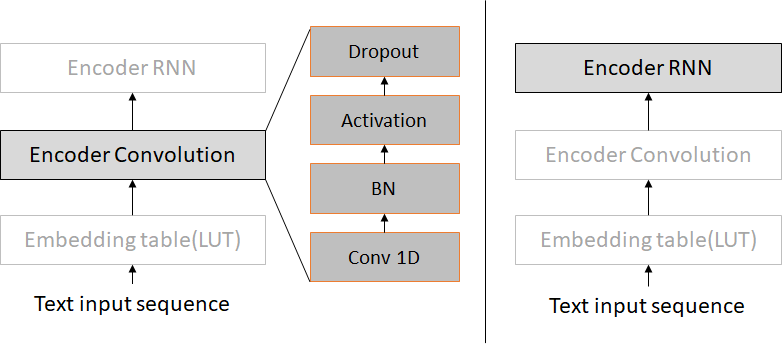

In [ ]:
class TFTacotronEncoderConvs(tf.keras.layers.Layer):
    """Tacotron-2 Encoder Convolutional Batchnorm module."""

    def __init__(self, config, **kwargs):
        """Init variables."""
        super().__init__(**kwargs)
        self.conv_batch_norm = []
        for i in range(config.n_conv_encoder):
            conv = TFTacotronConvBatchNorm(
                filters=config.encoder_conv_filters,
                kernel_size=config.encoder_conv_kernel_sizes,
                activation=config.encoder_conv_activation,
                dropout_rate=config.encoder_conv_dropout_rate,
                name_idx=i,
            )
            self.conv_batch_norm.append(conv)

    def call(self, inputs, training=False):
        """Call logic."""
        outputs = inputs
        for conv in self.conv_batch_norm:
            outputs = conv(outputs, training=training)
        return outputs


class TFTacotronEncoder(tf.keras.layers.Layer):
    """Tacotron-2 Encoder."""

    def __init__(self, config, **kwargs):
        """Init variables."""
        super().__init__(**kwargs)
        self.embeddings = TFTacotronEmbeddings(config, name="embeddings")
        self.convbn = TFTacotronEncoderConvs(config, name="conv_batch_norm")
        self.bilstm = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                units=config.encoder_lstm_units, return_sequences=True
            ),
            name="bilstm",
        )

        ## Speaker Embedding 부분 ## 
        if config.n_speakers > 1:
            self.encoder_speaker_embeddings = TFEmbedding(
                config.n_speakers,
                config.embedding_hidden_size,
                embeddings_initializer=get_initializer(config.initializer_range),
                name="encoder_speaker_embeddings",
            )
            self.encoder_speaker_fc = tf.keras.layers.Dense(
                units=config.encoder_lstm_units * 2, name="encoder_speaker_fc"
            )

        self.config = config

    def call(self, inputs, training=False):
        
        """Call logic
        
            Encoder: Embedding Table => Encoder Conv => Encoder RNN 구조  
            Encoder Conv: (1d Conv -> 배치 Normalization -> activation -> dropout)
            이 Conv 레이어를 여러개 쌓음
        """
        input_ids, speaker_ids, input_mask = inputs

        # create embedding and mask them since we sum
        # speaker embedding to all character embedding.
        input_embeddings = self.embeddings([input_ids, speaker_ids], training=training)

        # pass embeddings to convolution batch norm
        conv_outputs = self.convbn(input_embeddings, training=training)

        # bi-lstm. 인코더는 Bi-Directional LSTM 사용
        outputs = self.bilstm(conv_outputs, mask=input_mask)

        if self.config.n_speakers > 1:
            encoder_speaker_embeddings = self.encoder_speaker_embeddings(speaker_ids)
            encoder_speaker_features = tf.math.softplus(
                self.encoder_speaker_fc(encoder_speaker_embeddings)
            )
            # extended encoderspeaker embeddings
            extended_encoder_speaker_features = encoder_speaker_features[
                :, tf.newaxis, :
            ]
            # sum to encoder outputs
            outputs += extended_encoder_speaker_features

        return outputs

### 3. Attention

PARAMS
----------------
- memory(X): 인코더 output
- mask: binary mask for padded data
- query(h): 디코더 output (batch, n_mel_channels * n_frames_per_step)
- energy 디코더와 인코더를 가지고 위치 정보 계산하는 것( e에 softmax를 취하면 attention weight이 나옴) 


Return
----------------
- alignment(y:location): (batch, max_time) 

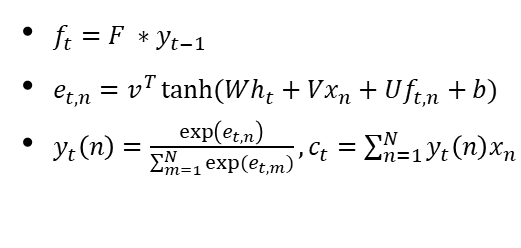

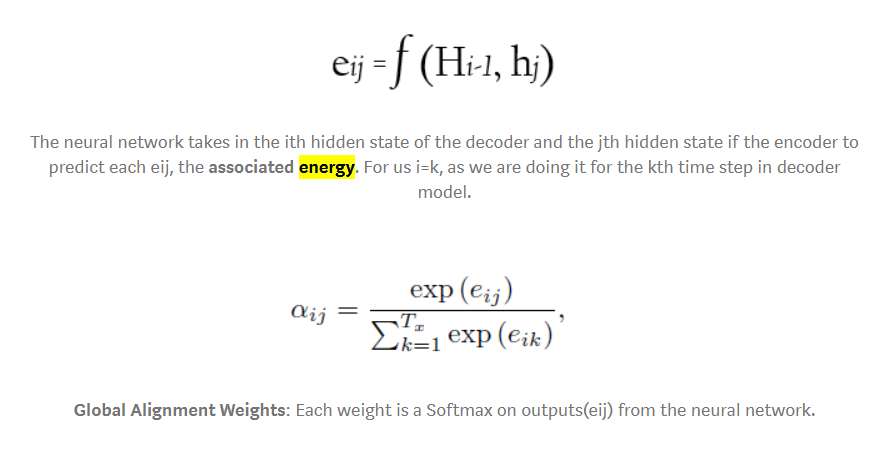

In [ ]:
class TFTacotronLocationSensitiveAttention(BahdanauAttention):
    """Tacotron-2 Location Sensitive Attention module."""

    def __init__(
        self,
        config,
        memory,
        mask_encoder=True,
        memory_sequence_length=None,
        is_cumulate=True,
    ):
        """Init variables."""
        memory_length = memory_sequence_length if (mask_encoder is True) else None
        super().__init__(
            units=config.attention_dim,
            memory=memory,
            memory_sequence_length=memory_length,
            probability_fn="softmax",
            name="LocationSensitiveAttention",
        )
        self.location_convolution = tf.keras.layers.Conv1D(
            filters=config.attention_filters,
            kernel_size=config.attention_kernel,
            padding="same",
            use_bias=False,
            name="location_conv",
        )
        self.location_layer = tf.keras.layers.Dense(
            units=config.attention_dim, use_bias=False, name="location_layer"
        )

        self.v = tf.keras.layers.Dense(1, use_bias=True, name="scores_attention")
        self.config = config
        self.is_cumulate = is_cumulate
        self.use_window = False

    def setup_window(self, win_front=2, win_back=4):
        self.win_front = tf.constant(win_front, tf.int32)
        self.win_back = tf.constant(win_back, tf.int32)

        self._indices = tf.expand_dims(tf.range(tf.shape(self.keys)[1]), 0)
        self._indices = tf.tile(
            self._indices, [tf.shape(self.keys)[0], 1]
        )  # [batch_size, max_time]

        self.use_window = True

    def _compute_window_mask(self, max_alignments):
        """Compute window mask for inference.
        Args:
            max_alignments (int): [batch_size]
        """
        expanded_max_alignments = tf.expand_dims(max_alignments, 1)  # [batch_size, 1]
        low = expanded_max_alignments - self.win_front
        high = expanded_max_alignments + self.win_back
        mlow = tf.cast((self._indices < low), tf.float32)
        mhigh = tf.cast((self._indices > high), tf.float32)
        mask = mlow + mhigh
        return mask  # [batch_size, max_length]

    def __call__(self, inputs, training=False):
        query, state, prev_max_alignments = inputs

        processed_query = self.query_layer(query) if self.query_layer else query
        processed_query = tf.expand_dims(processed_query, 1)

        expanded_alignments = tf.expand_dims(state, axis=2)
        f = self.location_convolution(expanded_alignments)
        processed_location_features = self.location_layer(f)

        energy = self._location_sensitive_score(
            processed_query, processed_location_features, self.keys
        )

        # mask energy on inference steps.
        if self.use_window is True:
            window_mask = self._compute_window_mask(prev_max_alignments)
            energy = energy + window_mask * -1e20

        alignments = self.probability_fn(energy, state)

        if self.is_cumulate:
            state = alignments + state
        else:
            state = alignments

        expanded_alignments = tf.expand_dims(alignments, 2)
        context = tf.reduce_sum(expanded_alignments * self.values, 1)

        return context, alignments, state

    def _location_sensitive_score(self, W_query, W_fil, W_keys):
        """Calculate location sensitive energy."""
        return tf.squeeze(self.v(tf.nn.tanh(W_keys + W_query + W_fil)), -1)

    def get_initial_state(self, batch_size, size):
        """Get initial alignments."""
        return tf.zeros(shape=[batch_size, size], dtype=tf.float32)

    def get_initial_context(self, batch_size):
        """Get initial attention."""
        return tf.zeros(
            shape=[batch_size, self.config.encoder_lstm_units * 2], dtype=tf.float32
        )


### 4. Decoder

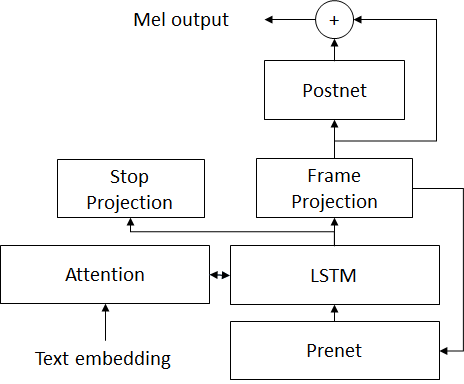

In [ ]:
class TFTacotronPrenet(tf.keras.layers.Layer):
    """Tacotron-2 prenet.
    
    Prenet은 Linear들을 여러개 쌓는 형태 
    각각의 Linear는 dropout을 거침 
    
    """

    def __init__(self, config, **kwargs):
        """Init variables."""
        super().__init__(**kwargs)
        self.prenet_dense = [
            tf.keras.layers.Dense(
                units=config.prenet_units,
                activation=ACT2FN[config.prenet_activation],
                name="dense_._{}".format(i),
            )
            for i in range(config.n_prenet_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(
            rate=config.prenet_dropout_rate, name="dropout"
        )

    def call(self, inputs, training=False):
        """Call logic."""
        outputs = inputs
        for layer in self.prenet_dense:
            outputs = layer(outputs)
            outputs = self.dropout(outputs, training=True)
        return outputs


class TFTacotronPostnet(tf.keras.layers.Layer):
    """Tacotron-2 postnet.
    
    1d Conv를 쭉 쌓은 형태 
    """

    def __init__(self, config, **kwargs):
        """Init variables."""
        super().__init__(**kwargs)
        self.conv_batch_norm = []
        for i in range(config.n_conv_postnet):
            conv = TFTacotronConvBatchNorm(
                filters=config.postnet_conv_filters,
                kernel_size=config.postnet_conv_kernel_sizes,
                dropout_rate=config.postnet_dropout_rate,
                activation="identity" if i + 1 == config.n_conv_postnet else "tanh",
                name_idx=i,
            )
            self.conv_batch_norm.append(conv)            
# 마지막 Conv 전까지는 activation f이 Tanh 
# 마지막 layer -> linear (mel을 regression할 수 있어야 하므로!)

    def call(self, inputs, training=False):
        """Call logic."""
        outputs = inputs
        for _, conv in enumerate(self.conv_batch_norm):
            outputs = conv(outputs, training=training)
        return outputs


TFTacotronDecoderCellState = collections.namedtuple(
    "TFTacotronDecoderCellState",
    [
        "attention_lstm_state",
        "decoder_lstms_state",
        "context",
        "time",
        "state",
        "alignment_history",
        "max_alignments",
    ],
)

TFDecoderOutput = collections.namedtuple(
    "TFDecoderOutput", ("mel_output", "token_output", "sample_id")
)


class TFTacotronDecoderCell(tf.keras.layers.AbstractRNNCell):
    """Tacotron-2 custom decoder cell."""

    def __init__(self, config, training, enable_tflite_convertible=False, **kwargs):
        """Init variables."""
        super().__init__(**kwargs)
        self.training = training
        self.enable_tflite_convertible = enable_tflite_convertible
        self.prenet = TFTacotronPrenet(config, name="prenet")

        # define lstm cell on decoder.
        # TODO(@dathudeptrai) switch to zone-out lstm.
        self.attention_lstm = tf.keras.layers.LSTMCell(
            units=config.decoder_lstm_units, name="attention_lstm_cell"
        )
        lstm_cells = []
        for i in range(config.n_lstm_decoder):
            lstm_cell = tf.keras.layers.LSTMCell(
                units=config.decoder_lstm_units, name="lstm_cell_._{}".format(i)
            )
            lstm_cells.append(lstm_cell)
        self.decoder_lstms = tf.keras.layers.StackedRNNCells(
            lstm_cells, name="decoder_lstms"
        )

        # define attention layer.
        if config.attention_type == "lsa":
            # create location-sensitive attention.
            self.attention_layer = TFTacotronLocationSensitiveAttention(
                config,
                memory=None,
                mask_encoder=True,
                memory_sequence_length=None,
                is_cumulate=True,
            )
        else:
            raise ValueError("Only lsa (location-sensitive attention) is supported")

        # frame, stop projection layer.
        self.frame_projection = tf.keras.layers.Dense(
            units=config.n_mels * config.reduction_factor, name="frame_projection"
        )
        self.stop_projection = tf.keras.layers.Dense(
            units=config.reduction_factor, name="stop_projection"
        )

        self.config = config

    def set_alignment_size(self, alignment_size):
        self.alignment_size = alignment_size

    @property
    def output_size(self):
        """Return output (mel) size."""
        return self.frame_projection.units

    @property
    def state_size(self):
        """Return hidden state size."""
        return TFTacotronDecoderCellState(
            attention_lstm_state=self.attention_lstm.state_size,
            decoder_lstms_state=self.decoder_lstms.state_size,
            time=tf.TensorShape([]),
            attention=self.config.attention_dim,
            state=self.alignment_size,
            alignment_history=(),
            max_alignments=tf.TensorShape([1]),
        )

    def get_initial_state(self, batch_size):
        """Get initial states."""
        initial_attention_lstm_cell_states = self.attention_lstm.get_initial_state(
            None, batch_size, dtype=tf.float32
        )
        initial_decoder_lstms_cell_states = self.decoder_lstms.get_initial_state(
            None, batch_size, dtype=tf.float32
        )
        initial_context = tf.zeros(
            shape=[batch_size, self.config.encoder_lstm_units * 2], dtype=tf.float32
        )
        initial_state = self.attention_layer.get_initial_state(
            batch_size, size=self.alignment_size
        )
        if self.enable_tflite_convertible:
            initial_alignment_history = ()
        else:
            initial_alignment_history = tf.TensorArray(
                dtype=tf.float32, size=0, dynamic_size=True
            )
        return TFTacotronDecoderCellState(
            attention_lstm_state=initial_attention_lstm_cell_states,
            decoder_lstms_state=initial_decoder_lstms_cell_states,
            time=tf.zeros([], dtype=tf.int32),
            context=initial_context,
            state=initial_state,
            alignment_history=initial_alignment_history,
            max_alignments=tf.zeros([batch_size], dtype=tf.int32),
        )

    def call(self, inputs, states):
        """Call logic."""
        decoder_input = inputs

        # 1. apply prenet for decoder_input.
        prenet_out = self.prenet(
            decoder_input, training=self.training
        )  # [batch_size, dim]

        # 2. concat prenet_out and prev context vector
        # then use it as input of attention lstm layer.
        # 전 타임스텝의 decoder_output이 decoder_input으로 들어가고, attention_context 벡터의 결과를 concat해서 사용 
        attention_lstm_input = tf.concat([prenet_out, states.context], axis=-1)
        attention_lstm_output, next_attention_lstm_state = self.attention_lstm(
            attention_lstm_input, states.attention_lstm_state
        )

        # 3. compute context, alignment and cumulative alignment.
        # Cumulative alignment: 타코트론에서는 attention weight들이 나올때마다 지속적으로 더해줘서 최대한 attention이 우상승(monotonic)하게 만들어주는 방식
        prev_state = states.state
        if not self.enable_tflite_convertible:
            prev_alignment_history = states.alignment_history
        prev_max_alignments = states.max_alignments
        context, alignments, state = self.attention_layer(
            [attention_lstm_output, prev_state, prev_max_alignments],
            training=self.training,
        )

        # 4. run decoder lstm(s)
        decoder_lstms_input = tf.concat([attention_lstm_output, context], axis=-1)
        decoder_lstms_output, next_decoder_lstms_state = self.decoder_lstms(
            decoder_lstms_input, states.decoder_lstms_state
        )

        # 5. compute frame feature and stop token.
        #mel을 뽑는 linear projection과 stop token projection을 할 때 모두 decoder lstm 값에 decoder hidden과 attention context벡터의 concat을 넣어줌
        projection_inputs = tf.concat([decoder_lstms_output, context], axis=-1)
        decoder_outputs = self.frame_projection(projection_inputs)

        stop_inputs = tf.concat([decoder_lstms_output, decoder_outputs], axis=-1)
        stop_tokens = self.stop_projection(stop_inputs)

        
        # 6. save alignment history to visualize.
        if self.enable_tflite_convertible:
            alignment_history = ()
        else:
            alignment_history = prev_alignment_history.write(states.time, alignments)

        # 7. return new states.
        new_states = TFTacotronDecoderCellState(
            attention_lstm_state=next_attention_lstm_state,
            decoder_lstms_state=next_decoder_lstms_state,
            time=states.time + 1,
            context=context,
            state=state,
            alignment_history=alignment_history,
            max_alignments=tf.argmax(alignments, -1, output_type=tf.int32),
        )

        return (decoder_outputs, stop_tokens), new_states
        # 최종: mel, stop token 결과, attention_weight(align 관련 정보) return

class TFTacotronDecoder(Decoder):
    """Tacotron-2 Decoder."""

    def __init__(
        self,
        decoder_cell,
        decoder_sampler,
        output_layer=None,
        enable_tflite_convertible=False,
    ):
        """Initial variables."""
        self.cell = decoder_cell
        self.sampler = decoder_sampler
        self.output_layer = output_layer
        self.enable_tflite_convertible = enable_tflite_convertible

    def setup_decoder_init_state(self, decoder_init_state):
        self.initial_state = decoder_init_state

    def initialize(self, **kwargs):
        return self.sampler.initialize() + (self.initial_state,)

    @property
    def output_size(self):
        return TFDecoderOutput(
            mel_output=tf.nest.map_structure(
                lambda shape: tf.TensorShape(shape), self.cell.output_size
            ),
            token_output=tf.TensorShape(self.sampler.reduction_factor),
            sample_id=tf.TensorShape([1])
            if self.enable_tflite_convertible
            else self.sampler.sample_ids_shape,  # tf.TensorShape([])
        )

    @property
    def output_dtype(self):
        return TFDecoderOutput(tf.float32, tf.float32, self.sampler.sample_ids_dtype)

    @property
    def batch_size(self):
        return self.sampler._batch_size

    def step(self, time, inputs, state, training=False):
        (mel_outputs, stop_tokens), cell_state = self.cell(
            inputs, state, training=training
        )
        if self.output_layer is not None:
            mel_outputs = self.output_layer(mel_outputs)
        sample_ids = self.sampler.sample(
            time=time, outputs=mel_outputs, state=cell_state
        )
        (finished, next_inputs, next_state) = self.sampler.next_inputs(
            time=time,
            outputs=mel_outputs,
            state=cell_state,
            sample_ids=sample_ids,
            stop_token_prediction=stop_tokens,
        )

        outputs = TFDecoderOutput(mel_outputs, stop_tokens, sample_ids)
        return (outputs, next_state, next_inputs, finished)


### 5. Tacotron2

In [ ]:
class TFTacotron2(tf.keras.Model):
    """Tensorflow tacotron-2 model."""

    def __init__(self, config, **kwargs):
        """Initalize tacotron-2 layers."""
        training = kwargs.pop("training", False)
        enable_tflite_convertible = kwargs.pop("enable_tflite_convertible", False)
        super().__init__(self, **kwargs)
        self.encoder = TFTacotronEncoder(config, name="encoder")
        self.decoder_cell = TFTacotronDecoderCell(
            config,
            training=training,
            name="decoder_cell",
            enable_tflite_convertible=enable_tflite_convertible,
        )
        self.decoder = TFTacotronDecoder(
            self.decoder_cell,
            TrainingSampler(config) if training is True else TestingSampler(config),
            enable_tflite_convertible=enable_tflite_convertible,
        )
        self.postnet = TFTacotronPostnet(config, name="post_net")
        self.post_projection = tf.keras.layers.Dense(
            units=config.n_mels, name="residual_projection"
        )

        self.config = config
        self.use_window_mask = False
        self.maximum_iterations = 4000
        self.enable_tflite_convertible = enable_tflite_convertible

    def setup_window(self, win_front, win_back):
        """Call only for inference."""
        self.use_window_mask = True
        self.win_front = win_front
        self.win_back = win_back

    def setup_maximum_iterations(self, maximum_iterations):
        """Call only for inference."""
        self.maximum_iterations = maximum_iterations

    def _build(self):
        input_ids = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9]])
        input_lengths = np.array([9])
        speaker_ids = np.array([0])
        mel_outputs = np.random.normal(size=(1, 50, 80)).astype(np.float32)
        mel_lengths = np.array([50])
        self(
            input_ids,
            input_lengths,
            speaker_ids,
            mel_outputs,
            mel_lengths,
            10,
            training=True,
        )

    def call(
        self,
        input_ids,
        input_lengths,
        speaker_ids,
        mel_gts,
        mel_lengths,
        maximum_iterations=2000,
        use_window_mask=False,
        win_front=2,
        win_back=3,
        training=False,
        **kwargs,
    ):
        """Call logic."""
        # create input-mask based on input_lengths
        input_mask = tf.sequence_mask(
            input_lengths,
            maxlen=tf.reduce_max(input_lengths),
            name="input_sequence_masks",
        )

        # Encoder Step.
        encoder_hidden_states = self.encoder(
            [input_ids, speaker_ids, input_mask], training=training
        )

        batch_size = tf.shape(encoder_hidden_states)[0]
        alignment_size = tf.shape(encoder_hidden_states)[1]

        # Setup some initial placeholders for decoder step. Include:
        # 1. mel_gts, mel_lengths for teacher forcing mode.
        # 2. alignment_size for attention size.
        # 3. initial state for decoder cell.
        # 4. memory (encoder hidden state) for attention mechanism.
        self.decoder.sampler.setup_target(targets=mel_gts, mel_lengths=mel_lengths)
        self.decoder.cell.set_alignment_size(alignment_size)
        self.decoder.setup_decoder_init_state(
            self.decoder.cell.get_initial_state(batch_size)
        )
        self.decoder.cell.attention_layer.setup_memory(
            memory=encoder_hidden_states,
            memory_sequence_length=input_lengths,  # use for mask attention.
        )
        if use_window_mask:
            self.decoder.cell.attention_layer.setup_window(
                win_front=win_front, win_back=win_back
            )

        # run decode step.
        (
            (frames_prediction, stop_token_prediction, _),
            final_decoder_state,
            _,
        ) = dynamic_decode(
            self.decoder,
            maximum_iterations=maximum_iterations,
            enable_tflite_convertible=self.enable_tflite_convertible,
        )

        decoder_outputs = tf.reshape(
            frames_prediction, [batch_size, -1, self.config.n_mels]
        )
        stop_token_prediction = tf.reshape(stop_token_prediction, [batch_size, -1])

        residual = self.postnet(decoder_outputs, training=training)
        residual_projection = self.post_projection(residual)

        mel_outputs = decoder_outputs + residual_projection

        if self.enable_tflite_convertible:
            mask = tf.math.not_equal(
                tf.cast(
                    tf.reduce_sum(tf.abs(decoder_outputs), axis=-1), dtype=tf.int32
                ),
                0,
            )
            decoder_outputs = tf.expand_dims(
                tf.boolean_mask(decoder_outputs, mask), axis=0
            )
            mel_outputs = tf.expand_dims(tf.boolean_mask(mel_outputs, mask), axis=0)
            alignment_history = ()
        else:
            alignment_history = tf.transpose(
                final_decoder_state.alignment_history.stack(), [1, 2, 0]
            )

        return decoder_outputs, mel_outputs, stop_token_prediction, alignment_history

    @tf.function(
        experimental_relax_shapes=True,
        input_signature=[
            tf.TensorSpec([None, None], dtype=tf.int32, name="input_ids"),
            tf.TensorSpec([None,], dtype=tf.int32, name="input_lengths"),
            tf.TensorSpec([None,], dtype=tf.int32, name="speaker_ids"),
        ],
    )
    def inference(self, input_ids, input_lengths, speaker_ids, **kwargs):
        """Call logic."""
        # create input-mask based on input_lengths
        input_mask = tf.sequence_mask(
            input_lengths,
            maxlen=tf.reduce_max(input_lengths),
            name="input_sequence_masks",
        )

        # Encoder Step.
        encoder_hidden_states = self.encoder(
            [input_ids, speaker_ids, input_mask], training=False
        )

        batch_size = tf.shape(encoder_hidden_states)[0]
        alignment_size = tf.shape(encoder_hidden_states)[1]

        # Setup some initial placeholders for decoder step. Include:
        # 1. batch_size for inference.
        # 2. alignment_size for attention size.
        # 3. initial state for decoder cell.
        # 4. memory (encoder hidden state) for attention mechanism.
        # 5. window front/back to solve long sentence synthesize problems. (call after setup memory.)
        self.decoder.sampler.set_batch_size(batch_size)
        self.decoder.cell.set_alignment_size(alignment_size)
        self.decoder.setup_decoder_init_state(
            self.decoder.cell.get_initial_state(batch_size)
        )
        self.decoder.cell.attention_layer.setup_memory(
            memory=encoder_hidden_states,
            memory_sequence_length=input_lengths,  # use for mask attention.
        )
        if self.use_window_mask:
            self.decoder.cell.attention_layer.setup_window(
                win_front=self.win_front, win_back=self.win_back
            )

        # run decode step.
        (
            (frames_prediction, stop_token_prediction, _),
            final_decoder_state,
            _,
        ) = dynamic_decode(self.decoder, maximum_iterations=self.maximum_iterations)

        decoder_outputs = tf.reshape(
            frames_prediction, [batch_size, -1, self.config.n_mels]
        )
        stop_token_predictions = tf.reshape(stop_token_prediction, [batch_size, -1])

        residual = self.postnet(decoder_outputs, training=False)
        residual_projection = self.post_projection(residual)

        mel_outputs = decoder_outputs + residual_projection

        alignment_historys = tf.transpose(
            final_decoder_state.alignment_history.stack(), [1, 2, 0]
        )

        return decoder_outputs, mel_outputs, stop_token_predictions, alignment_historys

    @tf.function(
        experimental_relax_shapes=True,
        input_signature=[
            tf.TensorSpec([1, None], dtype=tf.int32, name="input_ids"),
            tf.TensorSpec([1,], dtype=tf.int32, name="input_lengths"),
            tf.TensorSpec([1,], dtype=tf.int32, name="speaker_ids"),
        ],
    )
    def inference_tflite(self, input_ids, input_lengths, speaker_ids, **kwargs):
        """Call logic."""
        # create input-mask based on input_lengths
        input_mask = tf.sequence_mask(
            input_lengths,
            maxlen=tf.reduce_max(input_lengths),
            name="input_sequence_masks",
        )

        # Encoder Step.
        encoder_hidden_states = self.encoder(
            [input_ids, speaker_ids, input_mask], training=False
        )

        batch_size = tf.shape(encoder_hidden_states)[0]
        alignment_size = tf.shape(encoder_hidden_states)[1]

        # Setup some initial placeholders for decoder step. Include:
        # 1. batch_size for inference.
        # 2. alignment_size for attention size.
        # 3. initial state for decoder cell.
        # 4. memory (encoder hidden state) for attention mechanism.
        # 5. window front/back to solve long sentence synthesize problems. (call after setup memory.)
        self.decoder.sampler.set_batch_size(batch_size)
        self.decoder.cell.set_alignment_size(alignment_size)
        self.decoder.setup_decoder_init_state(
            self.decoder.cell.get_initial_state(batch_size)
        )
        self.decoder.cell.attention_layer.setup_memory(
            memory=encoder_hidden_states,
            memory_sequence_length=input_lengths,  # use for mask attention.
        )
        if self.use_window_mask:
            self.decoder.cell.attention_layer.setup_window(
                win_front=self.win_front, win_back=self.win_back
            )

        # run decode step.
        (
            (frames_prediction, stop_token_prediction, _),
            final_decoder_state,
            _,
        ) = dynamic_decode(
            self.decoder,
            maximum_iterations=self.maximum_iterations,
            enable_tflite_convertible=self.enable_tflite_convertible,
        )

        decoder_outputs = tf.reshape(
            frames_prediction, [batch_size, -1, self.config.n_mels]
        )
        stop_token_predictions = tf.reshape(stop_token_prediction, [batch_size, -1])

        residual = self.postnet(decoder_outputs, training=False)
        residual_projection = self.post_projection(residual)

        mel_outputs = decoder_outputs + residual_projection

        if self.enable_tflite_convertible:
            mask = tf.math.not_equal(
                tf.cast(
                    tf.reduce_sum(tf.abs(decoder_outputs), axis=-1), dtype=tf.int32
                ),
                0,
            )
            decoder_outputs = tf.expand_dims(
                tf.boolean_mask(decoder_outputs, mask), axis=0
            )
            mel_outputs = tf.expand_dims(tf.boolean_mask(mel_outputs, mask), axis=0)
            alignment_historys = ()
        else:
            alignment_historys = tf.transpose(
                final_decoder_state.alignment_history.stack(), [1, 2, 0]
            )

        return decoder_outputs, mel_outputs, stop_token_predictions, alignment_historys

## Training

In [ ]:
# 데이터 config 파일 

# # This is the hyperparameter configuration file for Tacotron2 v1.
# # Please make sure this is adjusted for the KSS dataset. If you want to
# # apply to the other dataset, you might need to carefully change some parameters.
# # This configuration performs 200k iters but 65k iters is enough to get a good models.

# ###########################################################
# #                FEATURE EXTRACTION SETTING               #
# ###########################################################
# hop_size: 256            # Hop size.
# format: "npy"


# ###########################################################
# #              NETWORK ARCHITECTURE SETTING               #
# ###########################################################
# model_type: "tacotron2"

# tacotron2_params:
#     dataset: "kss"
#     embedding_hidden_size: 512
#     initializer_range: 0.02
#     embedding_dropout_prob: 0.1
#     n_speakers: 1
#     n_conv_encoder: 5
#     encoder_conv_filters: 512
#     encoder_conv_kernel_sizes: 5
#     encoder_conv_activation: 'relu'
#     encoder_conv_dropout_rate: 0.5
#     encoder_lstm_units: 256
#     n_prenet_layers: 2
#     prenet_units: 256
#     prenet_activation: 'relu'
#     prenet_dropout_rate: 0.5
#     n_lstm_decoder: 1
#     reduction_factor: 1
#     decoder_lstm_units: 1024
#     attention_dim: 128
#     attention_filters: 32
#     attention_kernel: 31
#     n_mels: 80
#     n_conv_postnet: 5
#     postnet_conv_filters: 512
#     postnet_conv_kernel_sizes: 5
#     postnet_dropout_rate: 0.1
#     attention_type: "lsa"

# ###########################################################
# #                  DATA LOADER SETTING                    #
# ###########################################################
# batch_size: 32             # Batch size.
# remove_short_samples: true # Whether to remove samples the length of which are less than batch_max_steps.
# allow_cache: true          # Whether to allow cache in dataset. If true, it requires cpu memory.
# mel_length_threshold: 32   # remove all targets has mel_length <= 32 
# is_shuffle: true           # shuffle dataset after each epoch.
# use_fixed_shapes: false    # use_fixed_shapes for training (2x speed-up)
#                            # refer (https://github.com/dathudeptrai/TensorflowTTS/issues/34#issuecomment-642309118)

# ###########################################################
# #             OPTIMIZER & SCHEDULER SETTING               #
# ###########################################################
# optimizer_params:
#     initial_learning_rate: 0.001
#     end_learning_rate: 0.00001
#     decay_steps: 150000          # < train_max_steps is recommend.
#     warmup_proportion: 0.02
#     weight_decay: 0.001
    
    
# ###########################################################
# #                    INTERVAL SETTING                     #
# ###########################################################
# train_max_steps: 200000                 # Number of training steps.
# save_interval_steps: 2000               # Interval steps to save checkpoint.
# eval_interval_steps: 500                # Interval steps to evaluate the network.
# log_interval_steps: 200                 # Interval steps to record the training log.
# start_schedule_teacher_forcing: 200001  # don't need to apply schedule teacher forcing.
# start_ratio_value: 0.5                  # start ratio of scheduled teacher forcing.
# schedule_decay_steps: 50000             # decay step scheduled teacher forcing.
# end_ratio_value: 0.0                    # end ratio of scheduled teacher forcing.
# ###########################################################
# #                     OTHER SETTING                       #
# ###########################################################
# num_save_intermediate_results: 1  # Number of results to be saved as intermediate results.

In [ ]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices("GPU")
for i in range(len(physical_devices)):
    tf.config.experimental.set_memory_growth(physical_devices[i], True)

import easydict
import argparse
import logging
import os

import numpy as np
import yaml
from tqdm import tqdm

import tensorflow_tts
from ttsexamples.tacotron2.tacotron_dataset import CharactorMelDataset
from tensorflow_tts.configs.tacotron2 import Tacotron2Config
from tensorflow_tts.models import TFTacotron2
from tensorflow_tts.optimizers import AdamWeightDecay, WarmUp
from tensorflow_tts.trainers import Seq2SeqBasedTrainer
from tensorflow_tts.utils import (calculate_2d_loss, calculate_3d_loss,
                                  return_strategy)


class Tacotron2Trainer(Seq2SeqBasedTrainer):
    """Tacotron2 Trainer class based on Seq2SeqBasedTrainer."""

    def __init__(
        self, config, strategy, steps=0, epochs=0, is_mixed_precision=False,
    ):
        """Initialize trainer.

        Args:
            steps (int): Initial global steps.
            epochs (int): Initial global epochs.
            config (dict): Config dict loaded from yaml format configuration file.
            is_mixed_precision (bool): Use mixed precision or not.

        """
        super(Tacotron2Trainer, self).__init__(
            steps=steps,
            epochs=epochs,
            config=config,
            strategy=strategy,
            is_mixed_precision=is_mixed_precision,
        )
        # define metrics to aggregates data and use tf.summary logs them
        self.list_metrics_name = [
            "stop_token_loss",
            "mel_loss_before",
            "mel_loss_after",
            "guided_attention_loss",
        ]
        self.init_train_eval_metrics(self.list_metrics_name)
        self.reset_states_train()
        self.reset_states_eval()

        self.config = config

    def compile(self, model, optimizer):
        super().compile(model, optimizer)
        self.binary_crossentropy = tf.keras.losses.BinaryCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE
        )
        self.mse = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE
        )
        self.mae = tf.keras.losses.MeanAbsoluteError(
            reduction=tf.keras.losses.Reduction.NONE
        )

    def _train_step(self, batch):
        """Here we re-define _train_step because apply input_signature make
        the training progress slower on my experiment. Note that input_signature
        is apply on based_trainer by default.
        """
        if self._already_apply_input_signature is False:
            self.one_step_forward = tf.function(
                self._one_step_forward, experimental_relax_shapes=True
            )
            self.one_step_evaluate = tf.function(
                self._one_step_evaluate, experimental_relax_shapes=True
            )
            self.one_step_predict = tf.function(
                self._one_step_predict, experimental_relax_shapes=True
            )
            self._already_apply_input_signature = True

        # run one_step_forward
        self.one_step_forward(batch)

        # update counts
        self.steps += 1
        self.tqdm.update(1)
        self._check_train_finish()

    def compute_per_example_losses(self, batch, outputs):
        """Compute per example losses and return dict_metrics_losses
        Note that all element of the loss MUST has a shape [batch_size] and 
        the keys of dict_metrics_losses MUST be in self.list_metrics_name.

        Args:
            batch: dictionary batch input return from dataloader
            outputs: outputs of the model
        
        Returns:
            per_example_losses: per example losses for each GPU, shape [B]
            dict_metrics_losses: dictionary loss.
        """
        (
            decoder_output,
            post_mel_outputs,
            stop_token_predictions,
            alignment_historys,
        ) = outputs

        mel_loss_before = calculate_3d_loss(
            batch["mel_gts"], decoder_output, loss_fn=self.mae
        )
        mel_loss_after = calculate_3d_loss(
            batch["mel_gts"], post_mel_outputs, loss_fn=self.mae
        )

        # calculate stop_loss
        max_mel_length = (
            tf.reduce_max(batch["mel_lengths"])
            if self.config["use_fixed_shapes"] is False
            else [self.config["max_mel_length"]]
        )
        stop_gts = tf.expand_dims(
            tf.range(tf.reduce_max(max_mel_length), dtype=tf.int32), 0
        )  # [1, max_len]
        stop_gts = tf.tile(
            stop_gts, [tf.shape(batch["mel_lengths"])[0], 1]
        )  # [B, max_len]
        stop_gts = tf.cast(
            tf.math.greater_equal(stop_gts, tf.expand_dims(batch["mel_lengths"], 1)),
            tf.float32,
        )

        stop_token_loss = calculate_2d_loss(
            stop_gts, stop_token_predictions, loss_fn=self.binary_crossentropy
        )

        # calculate guided attention loss.
        attention_masks = tf.cast(
            tf.math.not_equal(batch["g_attentions"], -1.0), tf.float32
        )
        loss_att = tf.reduce_sum(
            tf.abs(alignment_historys * batch["g_attentions"]) * attention_masks,
            axis=[1, 2],
        )
        loss_att /= tf.reduce_sum(attention_masks, axis=[1, 2])

        per_example_losses = (
            stop_token_loss + mel_loss_before + mel_loss_after + loss_att
        )

        dict_metrics_losses = {
            "stop_token_loss": stop_token_loss,
            "mel_loss_before": mel_loss_before,
            "mel_loss_after": mel_loss_after,
            "guided_attention_loss": loss_att,
        }

        return per_example_losses, dict_metrics_losses

    def generate_and_save_intermediate_result(self, batch):
        """Generate and save intermediate result."""
        import matplotlib.pyplot as plt

        # predict with tf.function for faster.
        outputs = self.one_step_predict(batch)
        (
            decoder_output,
            mel_outputs,
            stop_token_predictions,
            alignment_historys,
        ) = outputs
        mel_gts = batch["mel_gts"]

        # convert to tensor.
        # here we just take a sample at first replica.
        try:
            mels_before = decoder_output.values[0].numpy()
            mels_after = mel_outputs.values[0].numpy()
            mel_gts = mel_gts.values[0].numpy()
            alignment_historys = alignment_historys.values[0].numpy()
        except Exception:
            mels_before = decoder_output.numpy()
            mels_after = mel_outputs.numpy()
            mel_gts = mel_gts.numpy()
            alignment_historys = alignment_historys.numpy()

        # check directory
        utt_ids = batch["utt_ids"].numpy()
        dirname = os.path.join(self.config["outdir"], f"predictions/{self.steps}steps")
        if not os.path.exists(dirname):
            os.makedirs(dirname)

        for idx, (mel_gt, mel_before, mel_after, alignment_history) in enumerate(
            zip(mel_gts, mels_before, mels_after, alignment_historys), 0
        ):
            mel_gt = tf.reshape(mel_gt, (-1, 80)).numpy()  # [length, 80]
            mel_before = tf.reshape(mel_before, (-1, 80)).numpy()  # [length, 80]
            mel_after = tf.reshape(mel_after, (-1, 80)).numpy()  # [length, 80]

            # plot figure and save it
            utt_id = utt_ids[idx]
            figname = os.path.join(dirname, f"{utt_id}.png")
            fig = plt.figure(figsize=(10, 8))
            ax1 = fig.add_subplot(311)
            ax2 = fig.add_subplot(312)
            ax3 = fig.add_subplot(313)
            im = ax1.imshow(np.rot90(mel_gt), aspect="auto", interpolation="none")
            ax1.set_title("Target Mel-Spectrogram")
            fig.colorbar(mappable=im, shrink=0.65, orientation="horizontal", ax=ax1)
            ax2.set_title(f"Predicted Mel-before-Spectrogram @ {self.steps} steps")
            im = ax2.imshow(np.rot90(mel_before), aspect="auto", interpolation="none")
            fig.colorbar(mappable=im, shrink=0.65, orientation="horizontal", ax=ax2)
            ax3.set_title(f"Predicted Mel-after-Spectrogram @ {self.steps} steps")
            im = ax3.imshow(np.rot90(mel_after), aspect="auto", interpolation="none")
            fig.colorbar(mappable=im, shrink=0.65, orientation="horizontal", ax=ax3)
            plt.tight_layout()
            plt.savefig(figname)
            plt.close()

            # plot alignment
            figname = os.path.join(dirname, f"{idx}_alignment.png")
            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111)
            ax.set_title(f"Alignment @ {self.steps} steps")
            im = ax.imshow(
                alignment_history, aspect="auto", origin="lower", interpolation="none"
            )
            fig.colorbar(im, ax=ax)
            xlabel = "Decoder timestep"
            plt.xlabel(xlabel)
            plt.ylabel("Encoder timestep")
            plt.tight_layout()
            plt.savefig(figname)
            plt.close()

def main():
    """Run training process."""
    args = easydict.EasyDict({ "train_dir": './dump_test/train', 
                              "dev_dir": './dump_test/valid/', 
                              "use_norm": 1, 
                              "outdir": "./ttsexamples/tacotron2/exp/train.multiband_melgan.v3/", 
                              "config": './ttsexamples/tacotron2/conf/tacotron2.v1.yaml', 
                              "resume": '',
                              "verbose":0,
                             'mixed_precision':0,
                             'pretrained':''})
    # return strategy
    STRATEGY = return_strategy()

    # set mixed precision config
    if args.mixed_precision == 1:
        tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

    args.mixed_precision = bool(args.mixed_precision)
    args.use_norm = bool(args.use_norm)

    # set logger
    if args.verbose > 1:
        logging.basicConfig(
            level=logging.DEBUG,
            stream=sys.stdout,
            format="%(asctime)s (%(module)s:%(lineno)d) %(levelname)s: %(message)s",
        )
    elif args.verbose > 0:
        logging.basicConfig(
            level=logging.INFO,
            stream=sys.stdout,
            format="%(asctime)s (%(module)s:%(lineno)d) %(levelname)s: %(message)s",
        )
    else:
        logging.basicConfig(
            level=logging.WARN,
            stream=sys.stdout,
            format="%(asctime)s (%(module)s:%(lineno)d) %(levelname)s: %(message)s",
        )
        logging.warning("Skip DEBUG/INFO messages")

    # check directory existence
    if not os.path.exists(args.outdir):
        os.makedirs(args.outdir)

    # check arguments
    if args.train_dir is None:
        raise ValueError("Please specify --train-dir")
    if args.dev_dir is None:
        raise ValueError("Please specify --valid-dir")

    # load and save config
    with open(args.config) as f:
        config = yaml.load(f, Loader=yaml.Loader)
    config.update(vars(args))
    config["version"] = tensorflow_tts.__version__

    # get dataset
    if config["remove_short_samples"]:
        mel_length_threshold = config["mel_length_threshold"]
    else:
        mel_length_threshold = 0

    if config["format"] == "npy":
        charactor_query = "*-ids.npy"
        mel_query = "*-raw-feats.npy" if args.use_norm is False else "*-norm-feats.npy"
        charactor_load_fn = np.load
        mel_load_fn = np.load
    else:
        raise ValueError("Only npy are supported.")

    train_dataset = CharactorMelDataset(
        dataset=config["tacotron2_params"]["dataset"],
        root_dir=args.train_dir,
        charactor_query=charactor_query,
        mel_query=mel_query,
        charactor_load_fn=charactor_load_fn,
        mel_load_fn=mel_load_fn,
        mel_length_threshold=mel_length_threshold,
        reduction_factor=config["tacotron2_params"]["reduction_factor"],
        use_fixed_shapes=config["use_fixed_shapes"],
    )

    # update max_mel_length and max_char_length to config
    config.update({"max_mel_length": int(train_dataset.max_mel_length)})
    config.update({"max_char_length": int(train_dataset.max_char_length)})

    with open(os.path.join(args.outdir, "config.yml"), "w") as f:
        yaml.dump(config, f, Dumper=yaml.Dumper)
    for key, value in config.items():
        logging.info(f"{key} = {value}")

    train_dataset = train_dataset.create(
        is_shuffle=config["is_shuffle"],
        allow_cache=config["allow_cache"],
        batch_size=config["batch_size"] * STRATEGY.num_replicas_in_sync,
    )

    valid_dataset = CharactorMelDataset(
        dataset=config["tacotron2_params"]["dataset"],
        root_dir=args.dev_dir,
        charactor_query=charactor_query,
        mel_query=mel_query,
        charactor_load_fn=charactor_load_fn,
        mel_load_fn=mel_load_fn,
        mel_length_threshold=mel_length_threshold,
        reduction_factor=config["tacotron2_params"]["reduction_factor"],
        use_fixed_shapes=False,  # don't need apply fixed shape for evaluation.
    ).create(
        is_shuffle=config["is_shuffle"],
        allow_cache=config["allow_cache"],
        batch_size=config["batch_size"] * STRATEGY.num_replicas_in_sync,
    )

    # define trainer
    trainer = Tacotron2Trainer(
        config=config,
        strategy=STRATEGY,
        steps=0,
        epochs=0,
        is_mixed_precision=args.mixed_precision,
    )

    with STRATEGY.scope():
        # define model.
        tacotron_config = Tacotron2Config(**config["tacotron2_params"])
        tacotron2 = TFTacotron2(config=tacotron_config, training=True, name="tacotron2")
        tacotron2._build()
        tacotron2.summary()
        
        if len(args.pretrained) > 1:
            tacotron2.load_weights(args.pretrained, by_name=True, skip_mismatch=True)
            logging.info(f"Successfully loaded pretrained weight from {args.pretrained}.")

        # AdamW for tacotron2
        learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
            initial_learning_rate=config["optimizer_params"]["initial_learning_rate"],
            decay_steps=config["optimizer_params"]["decay_steps"],
            end_learning_rate=config["optimizer_params"]["end_learning_rate"],
        )

        learning_rate_fn = WarmUp(
            initial_learning_rate=config["optimizer_params"]["initial_learning_rate"],
            decay_schedule_fn=learning_rate_fn,
            warmup_steps=int(
                config["train_max_steps"]
                * config["optimizer_params"]["warmup_proportion"]
            ),
        )

        optimizer = AdamWeightDecay(
            learning_rate=learning_rate_fn,
            weight_decay_rate=config["optimizer_params"]["weight_decay"],
            beta_1=0.9,
            beta_2=0.98,
            epsilon=1e-6,
            exclude_from_weight_decay=["LayerNorm", "layer_norm", "bias"],
        )

        _ = optimizer.iterations

    # compile trainer
    trainer.compile(model=tacotron2, optimizer=optimizer)

    # start training
    try:
        trainer.fit(
            train_dataset,
            valid_dataset,
            saved_path=os.path.join(config["outdir"], "checkpoints/"),
            resume=args.resume,
        )
    except KeyboardInterrupt:
        trainer.save_checkpoint()
        logging.info(f"Successfully saved checkpoint @ {trainer.steps}steps.")


if __name__ == "__main__":
    main()
